In [6]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from lattice_utils import (
    MultiFileDataset,
    BinFileDataset,
    corr_2d,
    deformed_corr_2d,
    reweight,
    plot_hists,
)
from models import UNet, Conv1Layer
from engines import train

In [2]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.6.0+rocm6.4.1.git1ded221d
AMD Radeon™ RX 7700S


In [3]:
kernel_size = 21
lat_size = 128

In [4]:
train_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/train")
val_multi_file_ds = MultiFileDataset(folder="L_128/U-Net/val")

min_sep_1layer = lat_size // 4 - 1

train_single_file_ds = BinFileDataset(
    folder="L_128/U-Net/train",
    fname="L=128_cluster_T=1.0000_configs.bin",
    seps=(min_sep_1layer, min_sep_1layer),
    random_seps=True,
)

val_single_file_ds = BinFileDataset(
    folder="L_128/U-Net/val",
    fname="L=128_cluster_T=1.0000_configs.bin",
    seps=(min_sep_1layer, min_sep_1layer),
    random_seps=True,
)

In [21]:
conv1layer = Conv1Layer(lat_size=lat_size, kernel_size=kernel_size)
conv1layer.to(device)
# conv1layer.load_state_dict(torch.load("conv1layer_128.pth"))

Conv1Layer(
  (conv): Conv2d(1, 1, kernel_size=(21, 21), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)

In [22]:
optim = Adam(conv1layer.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optim, 30, 1e-5)

single_loader = DataLoader(train_single_file_ds, batch_size=64, shuffle=True, pin_memory=True)
single_val_loader = DataLoader(val_single_file_ds, batch_size=64, shuffle=False, pin_memory=True)

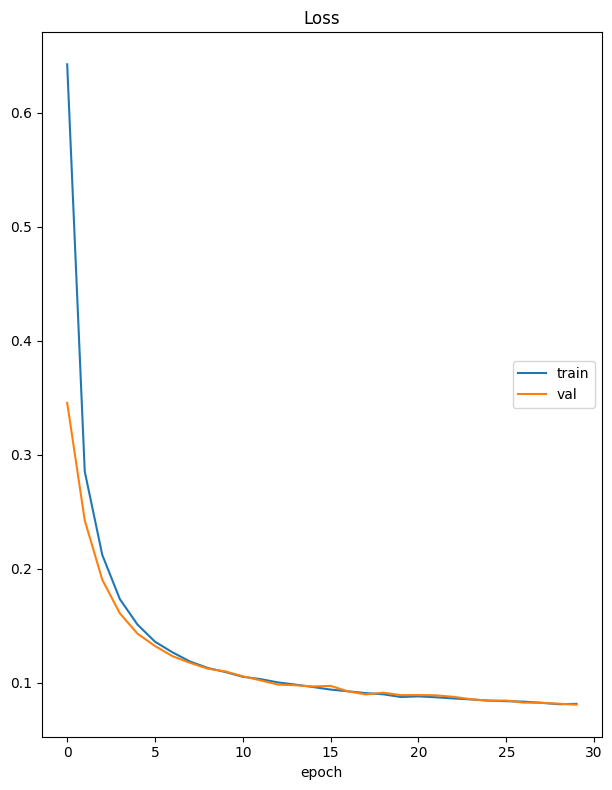

Loss
	train            	 (min:    0.081, max:    0.642, cur:    0.082)
	val              	 (min:    0.081, max:    0.346, cur:    0.081)


In [23]:
conv1layer.to(device)

train(
    model=conv1layer,
    loader=single_loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=30,
    device=device,
    val_loader=single_val_loader,
)

In [ ]:
# torch.save(conv1layer.state_dict(), "conv1layer_128.pth")

In [24]:
conv1layer.eval()

single_loader = DataLoader(train_single_file_ds, batch_size=1024)
temp = torch.tensor([1.1], device=device, dtype=torch.float32)
x = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)
y = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)

initial = []
deformed = []

shift_field = conv1layer(temp, x, y)

with torch.no_grad():
    for batch, inputs in enumerate(single_loader):
        inputs = tuple(input.to(device) for input in inputs)
        lats = inputs[0]
        # print(shift_field.size())
        deformed.append(deformed_corr_2d(lats, temp, shift_field, x, y))
        initial.append(corr_2d(lats, x, y))

initial = torch.cat(initial, dim=0).cpu()
deformed = torch.cat(deformed, dim=0).cpu()

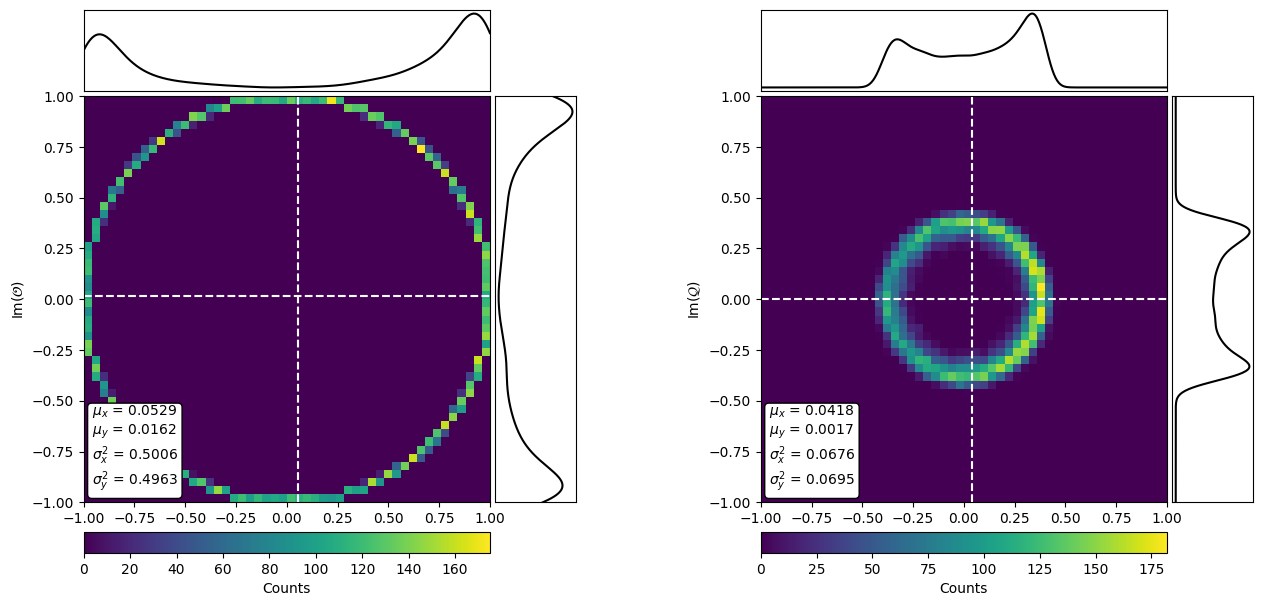

In [25]:
fig = plot_hists(initial, deformed)

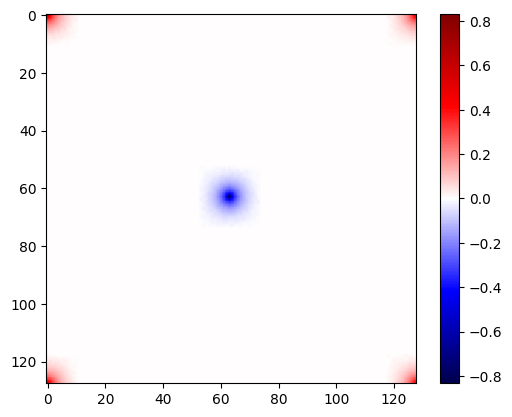

In [26]:
plt.imshow(shift_field.squeeze().cpu().detach().numpy(), cmap="seismic")
plt.colorbar()

**U-Net architecture for temperation and separation generalization**

Separation allowed to vary over the full lattice, and a set temperatures is used for training

Consider boltzmann reweighting to interpolate between temperatures?

Loss function:
$$\frac{1}{L^2}\sum_{\mathbf{x}\in\Lambda}\int_{t_0}^{t_1}dt\,\rho(t) \cdot \mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right]$$

$$\mathcal{L}\left[\Delta(\mathbf{x},t);\,\mathbf{x},t \right] = \left[\mathrm{Re}\left\langle \mathcal{Q(\mathbf{x},t)} \right\rangle\right]^2$$

$$\mathcal{Q}(\mathbf{x},t)=\exp\left[i(\tilde{\theta}(\mathbf{x},t) - \tilde{\theta}(\mathbf{0},t))\right]\cdot\exp\left[{-\beta(H(\tilde{\Omega})-H(\Omega))}\right]$$

$$\Omega=\left\{\theta(\mathbf{x}) | \mathbf{x}\in \Lambda\right\},\, \tilde{\theta}(\mathbf{x}) = \theta(\mathbf{x},t) + i\Delta(\mathbf{x,t})$$

With $\rho(t)$ some probability density that has support over $[t_0,t_1]$. Currently using a uniform sampling in $\beta$ rather than $t$, which amounts to the change of variables $d\beta=-dT/T^2$

In [5]:
unet = UNet(lat_size=128, min_size=4)
unet.load_state_dict(torch.load("unet_state_dict_128.pth"))
unet.to(device)

UNet(
  (encoder_expand_convs): ModuleList(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
  )
  (encoder_refine_convs): ModuleList(
    (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
training_sample_weights = reweight(
    torch.stack([train_multi_file_ds[i][1] for i in range(len(train_multi_file_ds))]).detach().numpy(),
    dist=lambda x: x**-2,
)

np.save("L_128/U-Net/train_sample_weights.npy", training_sample_weights)

In [12]:
training_sample_weights = np.load("L_128/U-Net/train_sample_weights.npy")

training_sample_weights

array([83.67347 , 83.67347 , 83.67347 , ..., 33.884296, 33.884296,
       33.884296], shape=(738000,), dtype=float32)

In [13]:
sampler = WeightedRandomSampler(training_sample_weights, num_samples=len(train_multi_file_ds), replacement=True)

In [14]:
multi_train_loader = DataLoader(train_multi_file_ds, batch_size=64, pin_memory=True, sampler=sampler)
multi_val_loader = DataLoader(val_multi_file_ds, batch_size=256, shuffle=False, pin_memory=True)

optim = Adam(unet.parameters(), lr=1e-3)
scheduler = CosineAnnealingWarmRestarts(optim, 2500, eta_min=1e-5)

In [ ]:
unet.train()

train(
    model=unet,
    loader=multi_train_loader,
    optimizer=optim,
    scheduler=scheduler,
    epochs=20,
    device=device,
    # val_loader=multi_val_loader,
)

In [ ]:
# torch.save(unet.state_dict(), "unet_state_dict_128.pth")

In [47]:
unet.eval()

init_corrs = []
def_corrs = []

for i in range(lat_size // 8, lat_size * 7 // 8 + 1, 2):  # Using every 2nd separation for efficiency
    print(f"Sep: x=y={i}")

    x = torch.tensor([i], device=device, dtype=torch.float32)
    y = torch.tensor([i], device=device, dtype=torch.float32)

    init_t_corrs = []
    def_t_corrs = []

    for ds in train_multi_file_ds.datasets[::2]:  # Using every 2nd temp for efficiency
        print(f"\tTemp: {ds.T}")

        with torch.no_grad():
            temp = torch.tensor([ds.T], device=device, dtype=torch.float32)
            shift_fields = unet(temp, x, y)

            loader = DataLoader(ds, batch_size=4096)
            init_batches = []
            def_batches = []

            for inputs in loader:
                inputs = tuple(inp.to(device) for inp in inputs)
                lats = inputs[0]

                init_batches.append(corr_2d(lats, x, y).cpu())
                def_batches.append(deformed_corr_2d(lats, temp, shift_fields, x, y).cpu())

            init_t_corrs.append(torch.cat(init_batches, dim=0))
            def_t_corrs.append(torch.cat(def_batches, dim=0))

    init_corrs.append(torch.stack(init_t_corrs, dim=0))
    def_corrs.append(torch.stack(def_t_corrs, dim=0))

init_corrs = torch.stack(init_corrs, dim=0)
def_corrs = torch.stack(def_corrs, dim=0)

Sep: x=y=16
	Temp: 0.7
	Temp: 0.72
	Temp: 0.74
	Temp: 0.76
	Temp: 0.78
	Temp: 0.8
	Temp: 0.82
	Temp: 0.84
	Temp: 0.86
	Temp: 0.88
	Temp: 0.9
	Temp: 0.92
	Temp: 0.94
	Temp: 0.96
	Temp: 0.98
	Temp: 1.0
	Temp: 1.02
	Temp: 1.04
	Temp: 1.06
	Temp: 1.08
	Temp: 1.1
Sep: x=y=18
	Temp: 0.7
	Temp: 0.72
	Temp: 0.74
	Temp: 0.76
	Temp: 0.78
	Temp: 0.8
	Temp: 0.82
	Temp: 0.84
	Temp: 0.86
	Temp: 0.88
	Temp: 0.9
	Temp: 0.92
	Temp: 0.94
	Temp: 0.96
	Temp: 0.98
	Temp: 1.0
	Temp: 1.02
	Temp: 1.04
	Temp: 1.06
	Temp: 1.08
	Temp: 1.1
Sep: x=y=20
	Temp: 0.7
	Temp: 0.72
	Temp: 0.74
	Temp: 0.76
	Temp: 0.78
	Temp: 0.8
	Temp: 0.82
	Temp: 0.84
	Temp: 0.86
	Temp: 0.88
	Temp: 0.9
	Temp: 0.92
	Temp: 0.94
	Temp: 0.96
	Temp: 0.98
	Temp: 1.0
	Temp: 1.02
	Temp: 1.04
	Temp: 1.06
	Temp: 1.08
	Temp: 1.1
Sep: x=y=22
	Temp: 0.7
	Temp: 0.72
	Temp: 0.74
	Temp: 0.76
	Temp: 0.78
	Temp: 0.8
	Temp: 0.82
	Temp: 0.84
	Temp: 0.86
	Temp: 0.88
	Temp: 0.9
	Temp: 0.92
	Temp: 0.94
	Temp: 0.96
	Temp: 0.98
	Temp: 1.0
	Temp: 1.02
	Temp: 1.04

In [48]:
torch.save((init_corrs, def_corrs), "corrs_128_full.pth")

In [43]:
init_corrs, def_corrs = torch.load("corrs_128.pth")

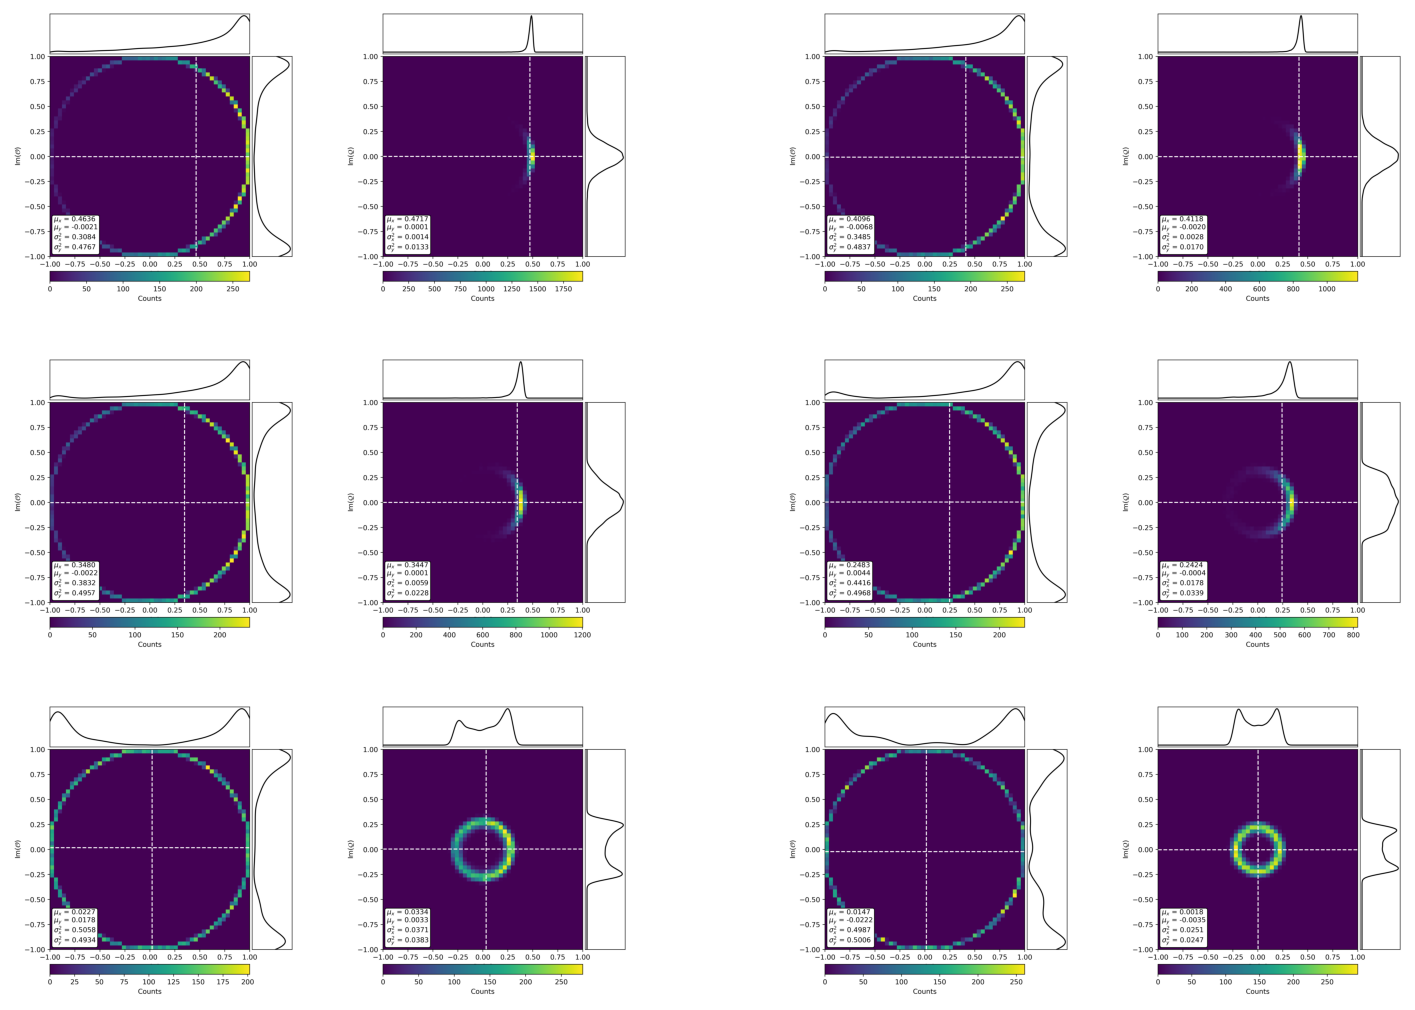

In [46]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np
from io import BytesIO
from PIL import Image

def plot_hists_grid_from_function(initials, deformeds, ncols=3):
    """
    Render each plot_hists() into an image and tile them in a grid.
    """

    N = len(initials)
    nrows = int(np.ceil(N / ncols))
    images = []

    for i in range(N):
        # Get the figure from plot_hists
        fig = plot_hists(initials[i], deformeds[i])

        # Render the figure to a PNG buffer
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=400)
        plt.close(fig)
        buf.seek(0)

        img = Image.open(buf).convert("RGB")
        images.append(img)

    # Now tile all rendered images in one big figure
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 9, nrows * 6), constrained_layout=False)
    axs = np.array(axs).reshape(-1)

    for i, ax in enumerate(axs):
        if i < len(images):
            ax.imshow(images[i])
        ax.axis('off')

    # Adjust vertical & horizontal spacing
    plt.subplots_adjust(hspace=-0.5, wspace=0.25)  # reduce these as needed

    plt.show()


l = init_corrs.size(0)  # Number of seps
plot_hists_grid_from_function(init_corrs[0,::4,:], def_corrs[0,::4,:], ncols=2)

In [11]:
unet.eval()

x = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)
y = torch.tensor([lat_size // 2 - 1], device=device, dtype=torch.float32)

tempwise_shift_fields = []

temps_range = np.linspace(0.7, 1.1, 41)

for T in temps_range:

    print(f"Processing temperature: {T}")

    with torch.no_grad():

        temp = torch.tensor([T], device=device, dtype=torch.float32)

        initial = []
        deformed = []

        shift_fields = unet(temp, x, y)

        tempwise_shift_fields.append(shift_fields.cpu())

tempwise_shift_fields = torch.cat(tempwise_shift_fields, dim=0)
tempwise_shift_fields_centred = tempwise_shift_fields - tempwise_shift_fields.mean(dim=(1,2), keepdim=True)

Processing temperature: 0.7
Processing temperature: 0.71
Processing temperature: 0.72
Processing temperature: 0.73
Processing temperature: 0.74
Processing temperature: 0.75
Processing temperature: 0.76
Processing temperature: 0.77
Processing temperature: 0.78
Processing temperature: 0.79
Processing temperature: 0.8
Processing temperature: 0.81
Processing temperature: 0.8200000000000001
Processing temperature: 0.8300000000000001
Processing temperature: 0.84
Processing temperature: 0.85
Processing temperature: 0.86
Processing temperature: 0.87
Processing temperature: 0.88
Processing temperature: 0.89
Processing temperature: 0.9
Processing temperature: 0.91
Processing temperature: 0.92
Processing temperature: 0.93
Processing temperature: 0.9400000000000001
Processing temperature: 0.9500000000000001
Processing temperature: 0.9600000000000001
Processing temperature: 0.97
Processing temperature: 0.98
Processing temperature: 0.99
Processing temperature: 1.0
Processing temperature: 1.01
Proces

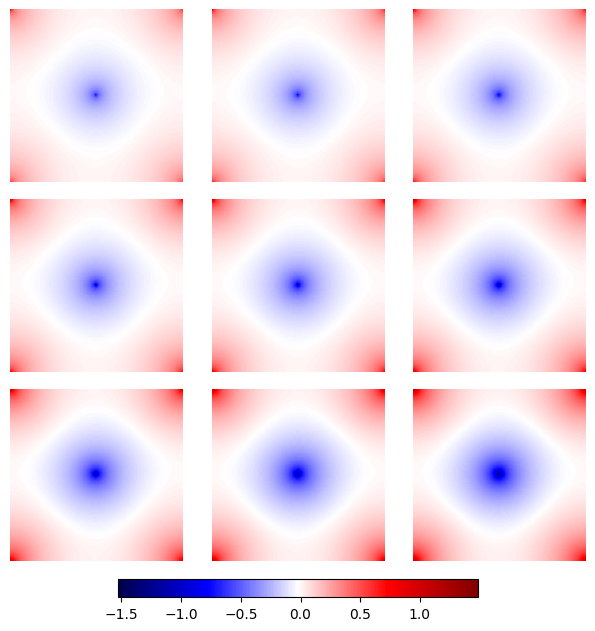

In [12]:
def plot_tensor_grid(tensor):
    assert tensor.ndim == 3, "Input tensor must have shape (N, L, L)"
    N, L1, L2 = tensor.shape
    assert L1 == L2, "Each slice must be square (L, L)"

    # Convert to numpy
    array = tensor.detach().cpu().numpy()

    # Determine grid size
    ncols = int(np.ceil(np.sqrt(N)))
    nrows = int(np.ceil(N / ncols))

    # Create figure and subplots with no gaps
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(2 * ncols, 2 * nrows),
        sharex=True, sharey=True,
        gridspec_kw=dict(wspace=.025, hspace=.1)
    )

    axes = axes.flat

    # Common color scale
    vmin = array.min()
    vmax = array.max()

    im = None
    for i in range(N):
        im = axes[i].imshow(array[i], vmin=vmin, vmax=vmax, cmap='seismic')
        axes[i].axis('off')

    for i in range(N, len(axes)):
        axes[i].axis('off')

    # Horizontal colorbar
    cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.03])
    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

    plt.subplots_adjust(left=0, right=1, top=1, bottom=0.08)
    plt.show()

tensor = tempwise_shift_fields_centred[::5]
plot_tensor_grid(tensor)

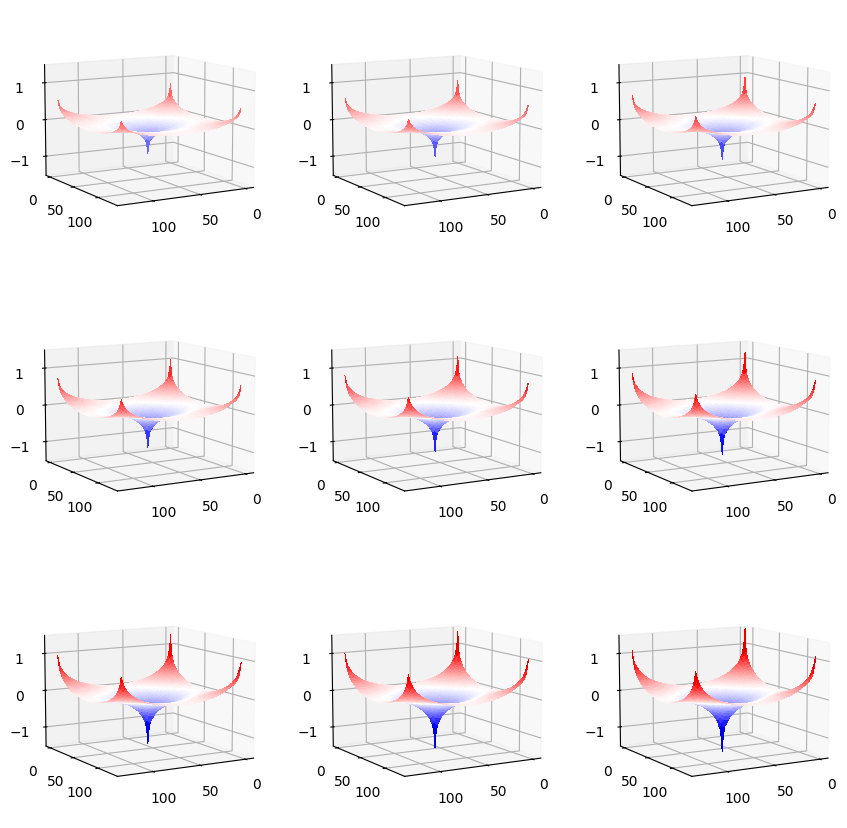

In [24]:
def plot_tensor_grid_3d(tensor, stride=1):
    assert tensor.ndim == 3, "Input tensor must have shape (N, L, L)"
    N, L1, L2 = tensor.shape
    assert L1 == L2, "Each slice must be square (L, L)"

    array = tensor.detach().cpu().numpy()

    # Downsample if needed
    array = array[::stride]
    N = array.shape[0]

    # Determine grid size
    ncols = int(np.ceil(np.sqrt(N)))
    nrows = int(np.ceil(N / ncols))

    fig = plt.figure(figsize=(3.5 * ncols, 3.5 * nrows))

    # Coordinate grid
    x = np.arange(L1)
    y = np.arange(L2)
    X, Y = np.meshgrid(x, y)

    vmin = array.min()
    vmax = array.max()

    for i in range(N):
        ax = fig.add_subplot(nrows, ncols, i + 1, projection='3d')
        ax.plot_surface(X, Y, array[i], cmap='seismic', vmin=vmin, vmax=vmax, linewidth=0, antialiased=False)
        ax.set_zlim(vmin, vmax)
        # ax.axis('off')  # optional: remove axes

        ax.view_init(elev=10, azim=60)

    # plt.tight_layout()
    plt.show()

tensor = tempwise_shift_fields_centred[::5]
plot_tensor_grid_3d(tensor)

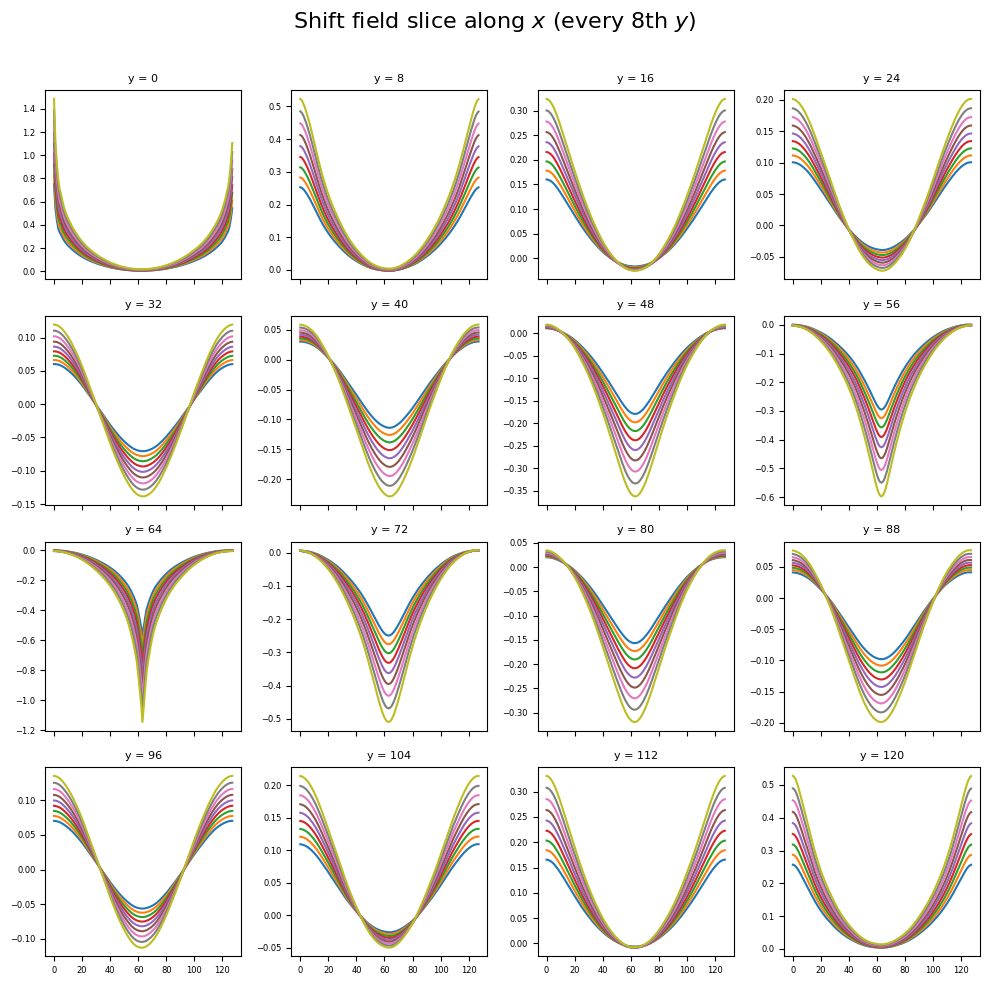

In [28]:
i_values = list(range(0, lat_size, 8))  # every 4th i

nplots = len(i_values)
ncols = int(np.ceil(np.sqrt(nplots)))
nrows = int(np.ceil(nplots / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols * 2.5, nrows * 2.5),
    sharex=True,
    # sharey=True
)

axes = axes.flat

for idx, i in enumerate(i_values):
    data = tempwise_shift_fields_centred[::5, i, :]
    axes[idx].plot(data.T.cpu().numpy())
    axes[idx].set_title(f"y = {i}", fontsize=8)
    axes[idx].tick_params(labelsize=6)

# Turn off unused axes
for j in range(nplots, len(axes)):
    axes[j].axis('off')

fig.suptitle("Shift field slice along $x$ (every 8th $y$)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
